In [529]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split , KFold
from sklearn.preprocessing import MinMaxScaler , LabelEncoder
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam , SGD
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



/kaggle/input/crab-age-prediction/CrabAgePrediction.csv
/kaggle/input/playground-series-s3e16/sample_submission.csv
/kaggle/input/playground-series-s3e16/train.csv
/kaggle/input/playground-series-s3e16/test.csv


In [530]:
#อ่านข้อมูลจากไฟล์
import pandas as pd
dftrain = pd.read_csv('/kaggle/input/playground-series-s3e16/train.csv')
dftest = pd.read_csv('/kaggle/input/playground-series-s3e16/test.csv')

print('The dimension of dftrain',dftrain.shape)
print('The dimension of dftest',dftest.shape)
# missing = df.isnull().sum()
# print(missing)

The dimension of dftrain (74051, 10)
The dimension of dftest (49368, 9)


In [531]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74051 entries, 0 to 74050
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              74051 non-null  int64  
 1   Sex             74051 non-null  object 
 2   Length          74051 non-null  float64
 3   Diameter        74051 non-null  float64
 4   Height          74051 non-null  float64
 5   Weight          74051 non-null  float64
 6   Shucked Weight  74051 non-null  float64
 7   Viscera Weight  74051 non-null  float64
 8   Shell Weight    74051 non-null  float64
 9   Age             74051 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 5.6+ MB


In [532]:
dftrain.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [533]:
#Data Cleaning

In [534]:
missingtrain = dftrain.isnull().sum()
missingtest = dftest.isnull().sum()
print(missingtrain)
print("---------------------")
print(missingtest)

id                0
Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
Age               0
dtype: int64
---------------------
id                0
Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
dtype: int64


In [535]:
#Summary Data
dftrain.describe()

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000
mean,37025.000000,1.317460,1.024496,0.348089,23.385217,10.104270,5.058386,6.723870,9.967806
std,21376.826729,0.287757,0.237396,0.092034,12.648153,5.618025,2.792729,3.584372,3.175189
min,0.000000,0.187500,0.137500,0.000000,0.056699,0.028349,0.042524,0.042524,1.000000
25%,18512.500000,1.150000,0.887500,0.300000,13.437663,5.712424,2.863300,3.968930,8.000000
50%,37025.000000,1.375000,1.075000,0.362500,23.799405,9.908150,4.989512,6.931453,10.000000
75%,55537.500000,1.537500,1.200000,0.412500,32.162508,14.033003,6.988152,9.071840,11.000000
max,74050.000000,2.012815,1.612500,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


In [536]:
print("number of zero in train['Height'] :", len(dftrain[dftrain['Height']==0]))
dftrain['Height'] = dftrain['Height'].replace({0:0.348089})
dftrain.describe()

number of zero in train['Height'] : 24


,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000
mean,37025.000000,1.317460,1.024496,0.348202,23.385217,10.104270,5.058386,6.723870,9.967806
std,21376.826729,0.287757,0.237396,0.091820,12.648153,5.618025,2.792729,3.584372,3.175189
min,0.000000,0.187500,0.137500,0.012500,0.056699,0.028349,0.042524,0.042524,1.000000
25%,18512.500000,1.150000,0.887500,0.300000,13.437663,5.712424,2.863300,3.968930,8.000000
50%,37025.000000,1.375000,1.075000,0.362500,23.799405,9.908150,4.989512,6.931453,10.000000
75%,55537.500000,1.537500,1.200000,0.412500,32.162508,14.033003,6.988152,9.071840,11.000000
max,74050.000000,2.012815,1.612500,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


In [537]:
dftrain

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8
...,...,...,...,...,...,...,...,...,...,...
74046,74046,F,1.6625,1.2625,0.4375,50.660556,20.680960,10.361742,12.332033,10
74047,74047,I,1.0750,0.8625,0.2750,10.446791,4.323299,2.296310,3.543687,6
74048,74048,F,1.4875,1.2000,0.4125,29.483480,12.303683,7.540967,8.079607,10
74049,74049,I,1.2125,0.9625,0.3125,16.768729,8.972617,2.919999,4.280774,8


In [538]:
#แปลงเพศให้เป็นตัวเลข
le = LabelEncoder()
dftrain['Sex'] = le.fit_transform(dftrain['Sex'])
dftest['Sex'] = le.fit_transform(dftest['Sex'])
dftrain

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,1,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,1,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,2,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,0,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,1,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8
...,...,...,...,...,...,...,...,...,...,...
74046,74046,0,1.6625,1.2625,0.4375,50.660556,20.680960,10.361742,12.332033,10
74047,74047,1,1.0750,0.8625,0.2750,10.446791,4.323299,2.296310,3.543687,6
74048,74048,0,1.4875,1.2000,0.4125,29.483480,12.303683,7.540967,8.079607,10
74049,74049,1,1.2125,0.9625,0.3125,16.768729,8.972617,2.919999,4.280774,8


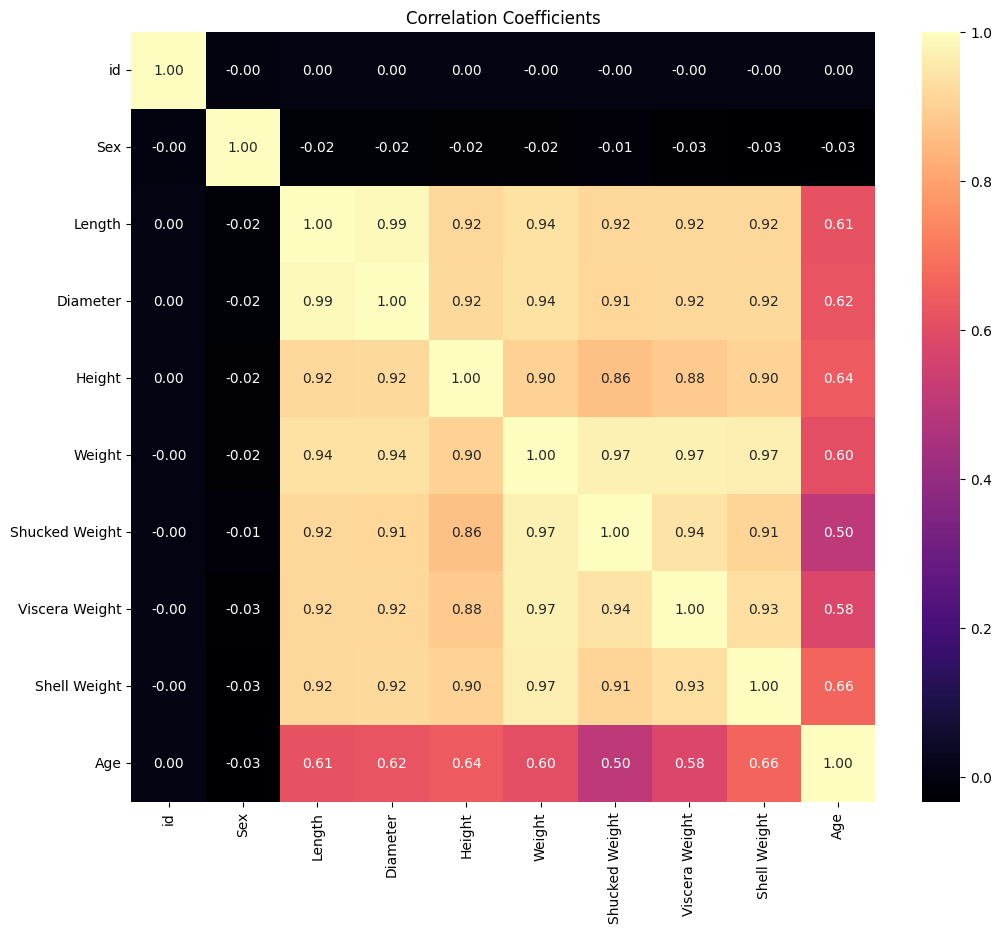

In [539]:

dftrain.corr()
corr = dftrain.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='magma', fmt=".2f")
plt.title("Correlation Coefficients")
plt.show()

In [540]:
X_Train = dftrain[['Shell Weight','Height','Diameter','Length']]
Y_Train = dftrain[['Age']]

X_Train1 = dftrain[['Sex','Length','Diameter','Height','Weight','Shucked Weight','Viscera Weight','Shell Weight']]
Y_Train1 = dftrain[['Age']]

Test = dftest[['Shell Weight','Height','Diameter','Length']]
Test1 = dftest[['Sex','Length','Diameter','Height','Weight','Shucked Weight','Viscera Weight','Shell Weight']]
# print(X_Train)
# print("------------------------------------")
# print(Test)

In [541]:
#normarlize ให้ค่าอยู่ระหว่าง 0 ถึง 1 
scaler = MinMaxScaler()
X_Train=pd.DataFrame(scaler.fit_transform(X_Train), index=X_Train.index, columns=X_Train.columns)
Test=pd.DataFrame(scaler.fit_transform(Test), index=Test.index, columns=Test.columns)
# print(X_Train)
# print('------------------')
# print(Test)

In [542]:
X_Train

,Shell Weight,Height,Diameter,Length
0,0.291978,0.128889,0.703390,0.732750
1,0.118087,0.093333,0.466102,0.499914
2,0.232686,0.128889,0.661017,0.657421
3,0.525660,0.173333,0.864407,0.828624
4,0.207773,0.115556,0.593220,0.582091
...,...,...,...,...
74046,0.431988,0.151111,0.762712,0.808080
74047,0.123069,0.093333,0.491525,0.486218
74048,0.282511,0.142222,0.720339,0.712206
74049,0.148979,0.106667,0.559322,0.561547


In [543]:
lr = LinearRegression()
lgb = LGBMRegressor(objective = 'mae',n_estimators = 1000,learning_rate = 0.01)
xgb = XGBRegressor(objective="reg:pseudohubererror",learning_rate = 0.01,n_estimators = 1000)
rf = RandomForestRegressor(n_estimators = 100,max_depth = 10)
mlp = Sequential()

mlp.add(Dense(128, activation='sigmoid', input_shape=(X_Train1.shape[1],)))
mlp.add(Dense(64, activation='sigmoid'))
mlp.add(Dense(1))
mlp.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

maeLRarr = []
maeLGBarr = []
maeXGBarr = []
maeRFarr = []
maeMLParr = []

cv = KFold(n_splits = 10)
i=0
for train_idx , test_idx in cv.split(X_Train1,Y_Train1):
    xxTrain , xxTest = X_Train.iloc[train_idx] , X_Train.iloc[test_idx]
    yyTrain , yyTest = Y_Train.iloc[train_idx] , Y_Train.iloc[test_idx]
    lr.fit(xxTrain,yyTrain)
    pred = lr.predict(xxTest)
    maeLR = np.sqrt(mean_absolute_error(yyTest, np.round(pred)))
    maeLRarr.append(maeLR)
    print('Fold', i, '==> LinearRegression of MAE is ==>', maeLR)
    i=i+1

k=0
for train_idx1 , test_idx1 in cv.split(X_Train1,Y_Train1):
    xxTrain1 , xxTest1 = X_Train1.iloc[train_idx1] , X_Train1.iloc[test_idx1]
    yyTrain1 , yyTest1 = Y_Train1.iloc[train_idx1] , Y_Train1.iloc[test_idx1]
    xgb.fit(xxTrain1,yyTrain1)
    lgb.fit(xxTrain1,yyTrain1)
    mlp.fit(xxTrain1, yyTrain1,batch_size=32, epochs=50,verbose=0)
    
    yyTrain1_flattened = np.ravel(yyTrain1)
    rf.fit(xxTrain1, yyTrain1_flattened)
    
    predXGB = xgb.predict(xxTest1)
    predLGB = lgb.predict(xxTest1)
    predMLP = mlp.predict(xxTest1)
    predRF = rf.predict(xxTest1)
    
    maeXGB = np.sqrt(mean_absolute_error(yyTest1, np.round(predXGB)))
    maeLGB = np.sqrt(mean_absolute_error(yyTest1, np.round(predLGB)))
    maeMLP = np.sqrt(mean_absolute_error(yyTest1, np.round(predMLP)))
    maeRF = np.sqrt(mean_absolute_error(yyTest1, np.round(predRF)))
    
    maeLGBarr.append(maeXGB)
    maeXGBarr.append(maeLGB)
    maeRFarr.append(maeMLP)
    maeMLParr.append(maeRF)
    
    print('Fold', k, '==> XGBoost of MAE is ==>', maeXGB)
    print('Fold', k, '==> LightGBM of MAE is ==>', maeLGB)
    print('Fold', k, '==> MLP of MAE is ==>', maeMLP)
    print('Fold', k, '==> RF of MAE is ==>', maeRF)
    k=k+1

Fold 0 ==> LinearRegression of MAE is ==> 1.2715864961225614
Fold 1 ==> LinearRegression of MAE is ==> 1.2717254490753078
Fold 2 ==> LinearRegression of MAE is ==> 1.2849831259713336
Fold 3 ==> LinearRegression of MAE is ==> 1.2836687800205548
Fold 4 ==> LinearRegression of MAE is ==> 1.2817210745309182
Fold 5 ==> LinearRegression of MAE is ==> 1.2732112341340638
Fold 6 ==> LinearRegression of MAE is ==> 1.270078445316906
Fold 7 ==> LinearRegression of MAE is ==> 1.294667815906807
Fold 8 ==> LinearRegression of MAE is ==> 1.278292243618231
Fold 9 ==> LinearRegression of MAE is ==> 1.2823530869334934
232/232 [==============================] - 0s 1ms/step
Fold 0 ==> XGBoost of MAE is ==> 1.4893174385006704
Fold 0 ==> LightGBM of MAE is ==> 1.5208071680341482
Fold 0 ==> MLP of MAE is ==> 1.187066861751903
Fold 0 ==> RF of MAE is ==> 1.1781038606397258
232/232 [==============================] - 0s 1ms/step
Fold 1 ==> XGBoost of MAE is ==> 1.4954804746640067
Fold 1 ==> LightGBM of MAE is ==

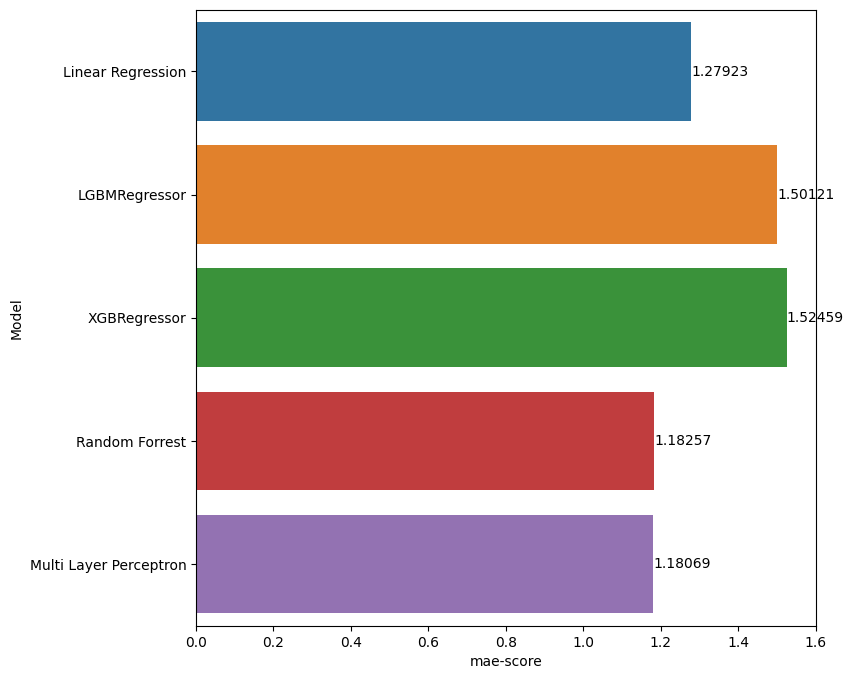

In [544]:
LR_score = np.mean(maeLRarr)
LGB_score = np.mean(maeLGBarr)
XGB_score = np.mean(maeXGBarr)
RF_score = np.mean(maeRFarr)
MLP_score = np.mean(maeMLParr)

model_perf = pd.DataFrame({'Model': ['Linear Regression', 'LGBMRegressor' ,'XGBRegressor', 'Random Forrest', 'Multi Layer Perceptron'],'mae-score': [LR_score, LGB_score, XGB_score, RF_score, MLP_score]})
plt.figure(figsize = (8, 8))
ax = sns.barplot(y = 'Model', x = 'mae-score', data = model_perf)
ax.bar_label(ax.containers[0]);

In [545]:
id = dftest['id']
final1 = np.round(lr.predict(Test))
final2 = np.round(xgb.predict(Test1))
final3 = np.round(lgb.predict(Test1))
final4 = np.round(mlp.predict(Test1))
final5 = np.round(rf.predict(Test1))

print(final1.shape)
final1 = final1.reshape(49368)
print(final1.shape)

print(final4.shape)
final4 = final4.reshape(49368)
print(final4.shape)

output1 = pd.DataFrame({'id': id,'Age': final1.astype(int)})
output2 = pd.DataFrame({'id': id,'Age': final2.astype(int)})
output3 = pd.DataFrame({'id': id,'Age': final3.astype(int)})
output4 = pd.DataFrame({'id': id,'Age': final4.astype(int)})
output5 = pd.DataFrame({'id': id,'Age': final5.astype(int)})

output1.to_csv('LinearRegression_submission.csv', index=False)
output2.to_csv('XGB_submission.csv', index=False)
output3.to_csv('LGB_submission.csv', index=False)
output4.to_csv('MLP_submission.csv', index=False)
output5.to_csv('RF_submission.csv', index=False)

1543/1543 [==============================] - 2s 1ms/step
(49368, 1)
(49368,)
(49368, 1)
(49368,)


In [548]:
with open("LinearRegression.pkl", 'wb') as file:
    pickle.dump(lr, file)
    
with open("XGBRegression.pkl", 'wb') as file:
    pickle.dump(xgb, file)

with open("LGBMRegression.pkl", 'wb') as file:
    pickle.dump(lgb, file)
    
with open("Random Forrest.pkl", 'wb') as file:
    pickle.dump(rf, file)
    
with open("Multi Layer Perceptron.pkl", 'wb') as file:
    pickle.dump(mlp, file)

In [547]:
# dftest = pd.read_csv('/kaggle/input/playground-series-s3e16/test.csv')
# dftest['Sex']=dftest['Sex'].replace({'I': 0, 'M': 1, 'F': 2})
# id=dftest['id']
# test=dftest[['Height','Length','Diameter','Weight','Shucked Weight','Viscera Weight','Shell Weight']]
# # print(test)
# test = pd.DataFrame(scaler.transform(test), index=test.index, columns=test.columns)
# # print(test)
# final = np.round(lr.predict(test))
# print(final)
# output = pd.DataFrame({'id': id,'Age': final.astype(int)})
# print(output)
# output.to_csv('submission.csv', index=False)